# Figure 4: GP+PCA detrended WLCs

## Setup

In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
import glob as glob
import matplotlib as mpl
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd
import seaborn as sns

import bz2
import corner
import json
import pathlib
import pickle
import utils
import warnings

from astropy import constants as const
from astropy import units as uni
from astropy.io import ascii, fits
from astropy.time import Time
from mpl_toolkits.axes_grid1 import ImageGrid

# Default figure dimensions
FIG_WIDE = (11, 5)
FIG_LARGE = (8, 11)

# Figure style
sns.set(style="ticks", palette="colorblind", color_codes=True, context="talk")
params = {
    # xticks
    "xtick.top": False,
    "xtick.direction": "out",
    "xtick.major.size": 5,
    "xtick.minor.visible": False,
    # yticks
    "ytick.right": False,
    "ytick.direction": "out",
    "ytick.major.size": 5,
    "ytick.minor.visible": False,
    # pallete
    "axes.prop_cycle": mpl.cycler(
        color=[
            "#fdbf6f",  # Yellow
            "#ff7f00",  # Orange
            "#a6cee3",  # Cyan
            "#1f78b4",  # Blue
            "#956cb4",  # Purple
            "#029e73",  # Green
            "#c44e52",  # Red
        ]
    ),
}
plt.rcParams.update(params)

<IPython.core.display.Javascript object>

## [Dowload data](https://www.dropbox.com/sh/biczfd95cz7ygot/AACBp6LgmFqFcYCkySwfo8qIa?dl=1)

This should be placed in a folder named `data` in the same level as this notebook

## Plot

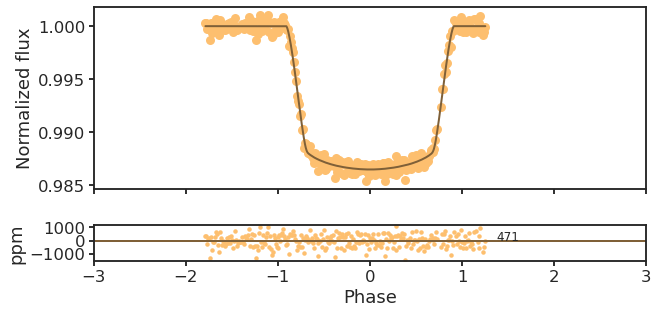

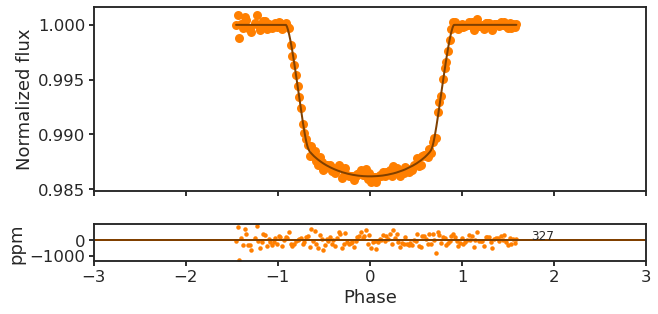

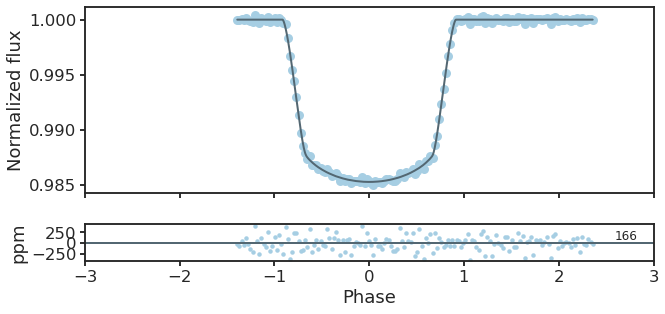

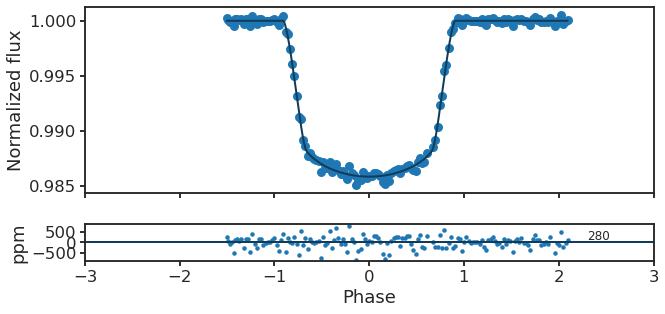

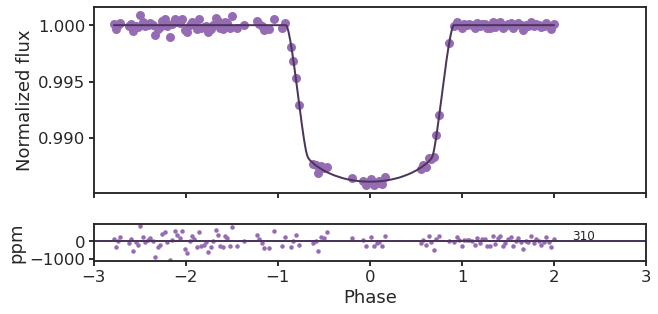

<IPython.core.display.Javascript object>

In [5]:
data_dir = "data/04"
fpaths = sorted(glob.glob(f"{data_dir}/hp*/white-light"))
fpath_dict = {f"Transit {i}": fpath for (i, fpath) in enumerate(fpaths, start=1)}
PCA = "PCA_2"  # Total number of principal components

for i, (transit_name, dirpath) in enumerate(fpath_dict.items()):
    fig, axes = plt.subplots(2, 1, sharex=True, gridspec_kw={"height_ratios": [5, 1]})
    ax_top, ax_bottom = axes

    # Get t0, P
    fpath_t0 = f"{dirpath}/results.dat"
    df_results = pd.read_table(fpath_t0, sep="\s+", index_col=0, escapechar="#")
    t0, P = df_results.loc[["t0", "P"]]["Value"]

    fpath = f"{dirpath}/{PCA}/detrended_lc.dat"

    # Detrended data
    t, detflux, detflux_err, model = np.genfromtxt(fpath, unpack=True)
    phase = utils.get_phases(t, P, t0)
    ax_top.plot(phase * 24, detflux, "o", label=transit_name, c=f"C{i}", mew=0)
    c_dark = 0.5 * np.array(mpl.colors.to_rgba(f"C{i}")[:3])

    # Full model
    t_full, f_full = np.genfromtxt(f"{dirpath}/full_model_{PCA}.dat").T
    phase_full = utils.get_phases(t_full, P, t0)
    p = ax_top.plot(phase_full * 24, f_full, color=c_dark, lw=2, zorder=10)

    # Residuals
    c = 2 * c_dark
    resids = detflux - model
    ax_bottom.plot(phase * 24, resids * 1e6, ".", mew=0, color=c)
    trans = transforms.blended_transform_factory(
        ax_bottom.transData, ax_bottom.transAxes
    )
    ax_bottom.axhline(0, lw=2, c=c_dark)

    rms = np.std(resids * 1e6)
    ax_bottom.annotate(
        f"{int(rms)}", xy=(1.1 * phase[-1] * 24, 0.58), xycoords=trans, fontsize=12
    )

    ax_top.set_xlim(-3, 3)
    ax_bottom.set_xlabel("Phase")
    ax_top.set_ylabel("Normalized flux")
    ax_bottom.set_ylabel("ppm")

    fig.tight_layout()
    fig.set_size_inches(FIG_WIDE)
    title = transit_name.lower().replace(" ", "_") + "_detr_wlcs"

    utils.savefig(f"../paper/figures/detrended_wlcs/{title}.pdf")

[Other notebooks](https://icweaver.github.io/HAT-P-23b/)